# Implemented: Conway's Game Of Life 

Progress:  10% | Elapsed:   0.7s | Remaining:   6.1s
Progress:  20% | Elapsed:   0.9s | Remaining:   3.6s
Progress:  30% | Elapsed:   1.0s | Remaining:   2.4s
Progress:  40% | Elapsed:   1.2s | Remaining:   1.8s
Progress:  50% | Elapsed:   1.3s | Remaining:   1.3s
Progress:  60% | Elapsed:   1.4s | Remaining:   0.9s
Progress:  70% | Elapsed:   1.6s | Remaining:   0.7s
Progress:  80% | Elapsed:   1.7s | Remaining:   0.4s
Progress:  90% | Elapsed:   1.8s | Remaining:   0.2s
Progress: 100% | Elapsed:   1.9s | Remaining:   0.0s


[ Info: Saved animation to /Users/lb788/Documents/Julia_Review_CfRR/CfRR_Courses/individual_modules/introduction_to_julia/data/life_naive.gif


Saved animation to data/life_naive.gif
Saved heatmap to data/life_history_heatmap.png


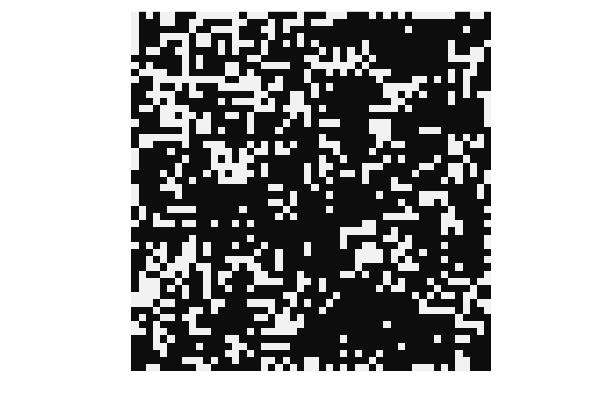

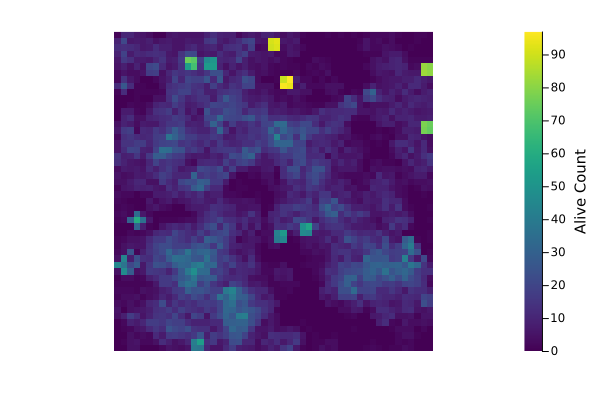

  3.147594 seconds (9.52 M allocations: 476.319 MiB, 3.32% gc time, 43.79% compilation time: 4% of which was recompilation)


In [1]:
using Random
using Plots
using Printf
using IJulia

"""
    count_neighbors_naive(grid::Matrix{Bool}, i::Int, j::Int) -> Int

Count the number of “alive” (true) neighbors surrounding the cell at
row `i`, column `j` in a boolean grid, scanning all eight adjacent
positions. Cells outside the boundaries are ignored.

# Arguments
- `grid::Matrix{Bool}`  
  A 2D array of Booleans representing the current state of each cell
  (e.g., in Conway’s Game of Life, `true` = alive, `false` = dead).

- `i::Int`, `j::Int`  
  The 1-based row and column indices of the cell whose neighbors
  should be counted.

# Returns
- `cnt::Int`  
  The total number of `true` values found in the eight surrounding
  cells.

# Notes
- Does *not* wrap around edges; neighbors off-grid are ignored.
- Naively checks all eight offsets (di, dj) in the range `-1:1`,
  skipping the (0,0) offset that refers to the cell itself.
"""
function count_neighbors_naive(grid::Matrix{Bool}, i::Int, j::Int)::Int
    # Initialize the neighbor count to zero
    cnt = 0

    # Loop over the relative offsets in row (di) and column (dj)
    for di in -1:1, dj in -1:1

        # Skip the (0,0) offset to avoid counting the cell itself
        if di != 0 || dj != 0
            # Compute the absolute neighbor coordinates
            i2, j2 = i + di, j + dj

            # Check bounds: only count if within the grid dimensions
            if 1 ≤ i2 ≤ size(grid,1) && 1 ≤ j2 ≤ size(grid,2)
                # Add 1 if the neighbor cell is `true` (alive)
                cnt += grid[i2, j2]
            end
        end
    end

    # Return the total count of alive neighbors
    return cnt
end

"""
    next_state_naive(grid::Matrix{Bool}) -> Matrix{Bool}

Compute the next generation of a boolean grid (e.g., for Conway’s Game of Life)
by applying the standard rules to each cell. This “naive” implementation
recalculates neighbor counts from scratch for every cell.

# Arguments
- `grid::Matrix{Bool}`  
  A 2D array of Booleans representing the current state of each cell
  (`true` = alive, `false` = dead).

# Returns
- `newgrid::Matrix{Bool}`  
  A new 2D Boolean array of the same size as `grid`, representing the
  state of each cell in the next generation.

# Rules Applied
1. Any live cell with 2 or 3 live neighbors survives.
2. Any dead cell with exactly 3 live neighbors becomes alive.
3. All other cells die or remain dead.
"""
function next_state_naive(grid::Matrix{Bool})::Matrix{Bool}
    # Get grid dimensions: N1 rows, N2 columns
    N1, N2 = size(grid)

    # Pre-allocate a new grid of the same size, initially all false (dead)
    newgrid = falses(N1, N2)

    # Loop over every cell position (i, j)
    for i in 1:N1, j in 1:N2
        # Count the live neighbors around (i, j)
        cnt = count_neighbors_naive(grid, i, j)


        # Apply the Game of Life rules:
        # - A live cell stays alive if it has 2 or 3 neighbors.
        # - A dead cell becomes alive if it has exactly 3 neighbors.
        # Otherwise it remains or becomes dead.
        newgrid[i,j] = (grid[i,j] && (cnt == 2 || cnt == 3)) ||
                       (!grid[i,j] && cnt == 3)
    end

    # Return the updated grid for the next generation
    return newgrid
end

#─── Main Simulation Function ───────────────────────────────────────────────────

"""
    run_naive_simulation(grid::Matrix{Bool}, steps::Int; print_interval_percent::Int=10)

Run a naive Game of Life simulation for a given number of steps,  
printing progress at regular intervals, accumulating a history of  
cell activity, and producing an animated GIF and a final heatmap of  
activity.

# Arguments
- `grid::Matrix{Bool}`  
  Initial boolean grid (`true` = alive, `false` = dead).

- `steps::Int`  
  Total number of generations to simulate.

- `print_interval_percent::Int=10`  
  Percentage intervals at which to print progress updates  
  (default: every 10% of `steps`).

# Side Effects
- Prints progress lines to STDOUT at each interval.
- Saves `data/life_naive.gif` showing the evolution.
- Saves `data/life_history_heatmap.png` showing the total times each cell was alive.
- Displays the animation and heatmap inline if running in a notebook; otherwise, reports file paths.
"""
function run_naive_simulation(grid::Matrix{Bool}, steps::Int; print_interval_percent::Int=10)

    # Get grid dimensions
    N1, N2 = size(grid)

    # history keeps track of how many times each cell was alive
    history = zeros(Int, N1, N2)

    # Compute how many steps correspond to one print interval:
    # at least 1, scaled by the given percentage of total steps
    step_interval = max(1, floor(Int, steps * print_interval_percent / 100))

    # Record the start time for elapsed/remaining estimation
    t_start = time()

    # Create an animation by collecting frames in the @animate block
    anim = @animate for step in 1:steps
        # Compute the next generation
        grid = next_state_naive(grid)

        # Accumulate the alive cells into history (Bool promoted to Int)
        history .+= grid  # Bool→0/1 promoted to Int

        # If we've reached a print interval, output progress stats
        if step % step_interval == 0
            pct     = step / steps * 100
            elapsed = time() - t_start
            avg     = elapsed / step
            remain  = avg * (steps - step)
            @printf("Progress: %3.0f%% | Elapsed: %5.1fs | Remaining: %5.1fs\n",
                    pct, elapsed, remain)
        end

        # Generate a heatmap frame for the current grid state
        heatmap(
            grid;
            color = :grays,
            axis = false,
            legend = false,
            framestyle = :none,
            aspect_ratio = 1
        )
    end
    
    # Ensure the “data” directory exists
    mkpath("data")

    # Write the animation to GIF at 10 frames per second
    gif(anim, "data/life_naive.gif"; fps = 10)
    println("Saved animation to data/life_naive.gif")
    
    
    # Plot the history heatmap: how many times each cell was alive
    heatmap(
        history;
        color = :viridis,
        framestyle = :none,      # no frame or axis lines
        axis = false,            # no tick marks or labels
        grid = false,            # no background grid lines
        colorbar_title = "Alive Count",
        aspect_ratio = 1
    )

    # Save the history heatmap as a PNG
    savefig("data/life_history_heatmap.png")
    println("Saved heatmap to data/life_history_heatmap.png")


    # Detect if running inside a Jupyter notebook
    in_notebook = isdefined(Main, :IJulia) && IJulia.inited

            
    if in_notebook
        # Display the GIF and PNG inline in the notebook
        display("image/gif", read("data/life_naive.gif"))
        display("image/png", read("data/life_history_heatmap.png"))
    else
        # Otherwise, instruct the user to open the files manually
        println("Not running in a notebook.")
        println("Open `data/life_naive.gif` and `data/life_history_heatmap.png` in your OS image viewer to see the results.")
    end

    
end

# Example usage:
# Create a 50×50 grid with random alive/dead cells and run
# the naive Game of Life simulation for 100 steps,
# printing progress every 10% of the total steps.
const N = 50
grid = rand(Bool, N, N)
@time run_naive_simulation(grid, 100; print_interval_percent = 10)